# LangGraphで作るAIエージェント実践入門

## 9.3 ハンズオン：Q&Aアプリケーション

In [3]:
# 諸々の環境設定
import os
from pathlib import Path
from dotenv import load_dotenv

dotenv_path = os.path.join(os.getcwd(), 'rag_ai_agent_book', '.env')
load_dotenv(dotenv_path)

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "rag-ai-agent-book"

In [4]:
# 専門家の定義を行なっている
ROLES={
	"1":{
		"name":"一般知識エキスパート",
		"description":"幅広い分野の一般的な質問に答える",
		"details":"幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。"
	},
	"2":{
		"name":"生成AI製品エキスパート",
		"description":"生成AIや関連商品、技術に関する専門的な質問に答える",
		"details":"生成AIや関連製品、技術関する専門的な質問に対して、最新の情報と深い洞察を提供してください。"
	},
	"3":{
		"name":"カウンセラー",
		"description":"個人的な悩みや心理的な問題に対してサポートを提供する",
		"details":"個人的な悩みや心理的な問題に対して、共感で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください"
	}
}

In [5]:
# このセルはStateクラスとその関連インポートを定義

import operator  # operatorモジュールをインポート（標準ライブラリで、加算や比較などの関数型演算子を提供する）
from typing import Annotated  # 型アノテーション用のAnnotatedをインポート
from pydantic import BaseModel,Field  # PydanticのBaseModelとFieldをインポート

# ユーザーの状態を管理するStateクラスを定義
class State(BaseModel):
	# ユーザーからの質問内容
	query:str=Field(...,description="ユーザーからの質問")
	# 選定された回答ロール
	current_role:str=Field(default="",description="選定された回答ロール")
	# 回答履歴（リスト同士の加算を許可）
	messages:Annotated[list[str],operator.add] = Field(default=[],description="回答履歴")
	# 品質チェックの結果（True/False）
	current_judge:bool=Field(default=False ,description="品質チェックの結果")
	# 品質チェックの判定理由
	judgement_reason:str=Field(default="",description="品質チェックの判定理由")

In [6]:
# OpenAIのgpt-4oモデルを初期化し、max_tokensパラメータを動的に変更できるように設定

from langchain_openai import ChatOpenAI  # OpenAIのチャットモデル用ラッパー
from langchain_core.runnables import ConfigurableField  # 実行時にパラメータ変更可能なフィールド

# OpenAIのgpt-4oモデルを温度0で初期化
llm=ChatOpenAI(model="gpt-4o", temperature=0)
# max_tokensを後から変更できるように設定
llm=llm.configurable_fields(max_tokens=ConfigurableField(id="max_tokens"))



In [7]:

from typing import Any  # 標準型ヒント用
from langchain_core.prompts import ChatPromptTemplate  # プロンプトテンプレート生成
from langchain_core.output_parsers import StrOutputParser  # 出力文字列パーサ

# 質問内容から最適なロールを選択するノードの処理
def selection_node(state:State)->dict[str,Any]:
	# ユーザーの質問を取得
	query=state.query
	# ロール選択肢を整形して文字列化
	role_options="\n".join(  # 各ロールの説明を改行区切りで連結
		[f"{k}.{v['name']}: {v['description']}" for k,v in ROLES.items()]  # ロール番号・名前・説明を整形

	)

	# 質問分析とロール選択を促すプロンプトを作成
	prompt=ChatPromptTemplate.from_template("""
		質問を分析し、最も適切な回答担当ロールを選択してください。
		選択肢:{role_options}
		回答は選択肢の番号(1,2,3)のみを返してください。

		質問:{query}
	""".strip()  # 文字列の先頭と末尾の空白文字（スペースや改行など）を取り除く
	)

	# プロンプト→LLM（max_tokens=1）→出力パースのチェーンを構築
	chain=(  # チェーン全体の構築
		prompt  # プロンプト
		|llm.with_config(configurable=dict(max_tokens=1))  # 最大トークン数を1に設定
		|StrOutputParser()  # 出力を文字列としてパース
	)

	# チェーンを実行し、ロール番号を取得
	role_number=chain.invoke({"role_options":role_options,"query":query})
	# 選択されたロール名を取得
	selected_role=ROLES[role_number.strip()]["name"]
	# 選択ロールを辞書で返却
	return {"current_role":selected_role}

In [8]:
# 質問内容と選択されたロールに基づき、適切な回答を生成して返すノード
def answering_node(state:State)->dict[str,Any]:
	# stateからユーザーの質問を取得
	query=state.query
	# stateから現在のロール名を取得
	role=state.current_role
	# ロールの詳細情報を整形して文字列化
	role_deteils="\n".join(  # 各ロールの名前と詳細を1行ずつ連結
		[f"- {v['name']}:{v['details']}" for v in ROLES.values()]  # ロール情報をリスト内包表記で生成
	)
	# 回答用プロンプトを作成
	prompt=ChatPromptTemplate.from_template("""
		貴方は{role}として回答してください。以下の質問に対して、貴方の役割に基づいた適切な回答を提供してください。
		役割の詳細:{role_details}
		質問:{query}
		回答:
		""".strip()
	)
	# プロンプト・LLM・出力パーサーをパイプで連結しチェーンを構築
	chain=prompt|llm|StrOutputParser()
	# チェーンを実行して回答を生成
	answer=chain.invoke({"role":role,"role_details":role_deteils, "query":query})
	# 回答をリスト形式で辞書に格納して返却
	return {"messages":[answer]}

In [15]:
# 回答の品質を判定し、その結果と理由を返す処理

# 回答の品質判定結果を格納するデータモデル
class Judgement(BaseModel):
	# 判定結果（True/False）
	judge:bool=Field(default=False,description="判定結果")
	# 判定理由
	reason:str=Field(default="",description="判定理由")

# 回答の品質をチェックするノード関数
def check_node(state:State)->dict[str,Any]:
	# ユーザーからの質問を取得
	query=state.query
	# 直近の回答を取得
	answer=state.messages[-1]
	# チェック用プロンプトを作成
	prompt=ChatPromptTemplate.from_template("""
		以下の回答の品質をチェックし、問題っがある場合は'False'、問題がない場合は'True'を回答してください。また、その判断理由も説明してください。
		ユーザーからの質問:{query}
		回答:{answer}
	""".strip()
	)
	# プロンプト・LLM・構造化出力パーサーをパイプで連結
	chain=prompt|llm.with_structured_output(Judgement)
	# チェーンを実行して判定結果を取得
	result: Judgement = chain.invoke({"query": query, "answer": answer}) #戻り値（Judgement型のインスタンス）を result という変数に代入しています。

	# 判定結果と理由を辞書で返却
	return{
		"current_judge":result.judge,
		"judgement_reason":result.reason
	}

In [16]:
# Stateクラスをもとにワークフローグラフを構築し、ノードやエッジを設定する処理

# ワークフロー構築用のライブラリをインポート
from langgraph.graph import StateGraph  # ワークフロー構築用のライブラリ

# Stateクラスをもとにワークフローグラフのインスタンスを生成
workflow = StateGraph(State)

# selectionノードを追加
workflow.add_node("selection", selection_node)
# answeringノードを追加
workflow.add_node("answering", answering_node)
# checkノードを追加
workflow.add_node("check", check_node)

# エントリーポイント（開始ノード）をselectionに設定
workflow.set_entry_point("selection")
# selectionノードからansweringノードへのエッジを追加
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへのエッジを追加
workflow.add_edge("answering", "check")

In [17]:
# checkノードの判定結果に応じて次のノードを分岐させる条件付きエッジを追加する処理

from langgraph.graph import END  # ワークフローの終了ノードを表す定数

# checkノードから条件に応じてENDまたはselectionノードへ遷移するエッジを追加
workflow.add_conditional_edges(
    "check",  # 判定対象ノード
    lambda state: state.current_judge,  # 判定条件（state.current_judgeの値で分岐）
    {True: END, False: "selection"}  # TrueならEND、Falseならselectionへ
)

In [21]:
# ワークフローをコンパイルし、初期状態で実行して結果を取得する処理

# ワークフローをコンパイルして実行可能なオブジェクトを作成
compiled = workflow.compile()

# 初期状態（クエリを含むStateインスタンス）を作成
initial_state = State(query="生成AIについて教えてください")

# コンパイル済みワークフローに初期状態を渡して実行し、結果を取得
result = compiled.invoke(initial_state)

# 実行結果（Stateの内容）を表示
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AI（生成的人工知能）とは、人工知能の一分野であり、新しいデータやコンテンツを生成する能力を持つモデルやシステムを指します。これには、テキスト、画像、音声、動画などの多様な形式の生成が含まれます。生成AIの代表的な技術には、以下のようなものがあります。\n\n1. **自然言語処理（NLP）モデル**: 例えば、GPT（Generative Pre-trained Transformer）シリーズは、テキストの生成や翻訳、要約などに用いられます。これらのモデルは、大量のテキストデータを学習し、人間のように自然な文章を生成することができます。\n\n2. **画像生成モデル**: GAN（Generative Adversarial Networks）やVAE（Variational Autoencoders）などの技術を用いて、新しい画像を生成します。これにより、アート作品の創作や、現実には存在しない人物の顔を生成することが可能です。\n\n3. **音声合成**: TTS（Text-to-Speech）技術を用いて、テキストから自然な音声を生成します。これにより、音声アシスタントやナレーションの自動生成が可能になります。\n\n生成AIは、クリエイティブな分野やエンターテインメント、教育、医療など、さまざまな分野で応用されています。しかし、生成AIの利用には倫理的な課題も伴います。例えば、偽情報の生成や著作権の問題などが挙げられます。そのため、生成AIの開発と利用においては、倫理的な配慮と責任ある使用が求められています。\n\nこの分野は急速に進化しており、今後も新しい技術や応用が登場することが期待されています。'],
 'current_judge': True,
 'judgement_reason': '回答は生成AIについての基本的な情報を網羅しており、自然言語処理、画像生成、音声合成などの具体例を挙げて説明しています。また、生成AIの応用分野や倫理的な課題についても触れており、全体としてバランスの取れた内容です。特に誤った情報や不正確な記述は見当たらず、ユーザーの質問に対して適切に答えています。'}

In [22]:
print(result["messages"][-1])

生成AI（生成的人工知能）とは、人工知能の一分野であり、新しいデータやコンテンツを生成する能力を持つモデルやシステムを指します。これには、テキスト、画像、音声、動画などの多様な形式の生成が含まれます。生成AIの代表的な技術には、以下のようなものがあります。

1. **自然言語処理（NLP）モデル**: 例えば、GPT（Generative Pre-trained Transformer）シリーズは、テキストの生成や翻訳、要約などに用いられます。これらのモデルは、大量のテキストデータを学習し、人間のように自然な文章を生成することができます。

2. **画像生成モデル**: GAN（Generative Adversarial Networks）やVAE（Variational Autoencoders）などの技術を用いて、新しい画像を生成します。これにより、アート作品の創作や、現実には存在しない人物の顔を生成することが可能です。

3. **音声合成**: TTS（Text-to-Speech）技術を用いて、テキストから自然な音声を生成します。これにより、音声アシスタントやナレーションの自動生成が可能になります。

生成AIは、クリエイティブな分野やエンターテインメント、教育、医療など、さまざまな分野で応用されています。しかし、生成AIの利用には倫理的な課題も伴います。例えば、偽情報の生成や著作権の問題などが挙げられます。そのため、生成AIの開発と利用においては、倫理的な配慮と責任ある使用が求められています。

この分野は急速に進化しており、今後も新しい技術や応用が登場することが期待されています。


In [ ]:
initial_state = State(query="生成AIについて教えてください")
result = await compiled.ainvoke(initial_state)
result

In [ ]:
# Homebrewでグラフ行がソフトをインストールする
# brew install graphviz

# パスを通して仮想環境にインストール
# export CPATH=/opt/homebrew/opt/graphviz/include && export LIBRARY_PATH=/opt/homebrew/opt/graphviz/lib && ./.venv/bin/pip install pygraphviz

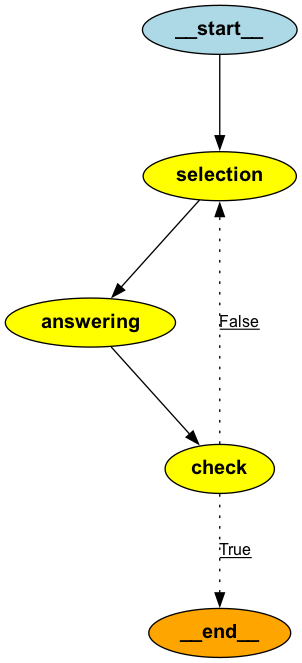

In [26]:
# ワークフローグラフをPNG画像として描画し、ノートブック上に表示する

from IPython.display import Image  # Jupyterノートブックで画像を表示するためのライブラリ

# ワークフローグラフをPNG画像として生成し表示
Image(compiled.get_graph().draw_png())

## 9.4 チェックポイント機能：ステートの永続化と再会

In [ ]:
# !pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 langgraph-checkpoint==1.0.11

In [13]:
# ステート管理とメッセージ追加、LLM応答を行うクラス・関数群

# 標準演算子モジュール
import operator  # 標準演算子を提供
# 型アノテーション用の型とユーティリティ
from typing import Annotated,Any  # 型ヒントと任意型
# LangChainのメッセージクラス
from langchain_core.messages import SystemMessage,HumanMessage,BaseMessage  # メッセージ型
# OpenAIのチャットモデル
from langchain_openai import ChatOpenAI  # OpenAIチャットモデル
# データバリデーション用のモデル
from pydantic import BaseModel,Field  # データモデルとフィールド

# ステート（状態）を管理するクラス
class State(BaseModel):
	# ユーザーからのクエリ
	query:str
	# メッセージ履歴（BaseMessage型のリスト、加算で連結）
	messages:Annotated[list[BaseMessage],operator.add]=Field(default=[])

# メッセージ履歴にシステム・ユーザーメッセージを追加する関数
def add_message(state:State)->dict[str,Any]:
	# 追加するメッセージを格納するリスト
	additional_message=[]
	# メッセージ履歴が空の場合はシステムメッセージを追加
	if not state.messages:
		additional_message.append(
			SystemMessage(content="貴方は最小限の応答をする対話エージェントです。")
		)
	# ユーザーのクエリをHumanMessageとして追加
	additional_message.append(HumanMessage(content=state.query))
	# 追加したメッセージを辞書で返す
	return {"messages":additional_message}

# LLMにメッセージ履歴を渡して応答を得る関数
def llm_response(state:State)->dict[str,Any]:
	# OpenAIのチャットモデルを初期化
	llm=ChatOpenAI(model="gpt-4o-mini",temperature=2)
	# メッセージ履歴をモデルに渡して応答を取得
	ai_message=llm.invoke(state.messages)
	# 応答メッセージを辞書で返す
	return {"messages":[ai_message]}

In [14]:
# チェックポイントの内容とメタデータを表示する関数を定義する

from pprint import pprint  # 標準ライブラリ、見やすく出力
from langchain_core.runnables import RunnableConfig  # LangChainの実行設定
from langgraph.checkpoint.base import BaseCheckpointSaver  # チェックポイント保存の基底クラス

# チェックポイントの内容とメタデータを出力する関数
def print_checkpoint_dump(checkpointer:BaseCheckpointSaver, config:RunnableConfig):
	# チェックポイントタプルを取得
	checkpoint_tuple = checkpointer.get_tuple(config)

	# チェックポイントデータを表示
	print("チェックポイントデータ：")
	pprint(checkpoint_tuple.checkpoint)
	# メタデータを表示
	print("\nメタデータ：")
	pprint(checkpoint_tuple.metadata)

In [15]:
# LangGraphを用いて状態遷移グラフを構築し、チェックポイント機能付きでコンパイルする

from langgraph.graph import StateGraph, END  # 状態遷移グラフ構築用
from langgraph.checkpoint.memory import MemorySaver  # メモリ上のチェックポイント保存

# 状態遷移グラフのインスタンスを作成
graph=StateGraph(State)
# add_messageノードをグラフに追加
graph.add_node("add_message",add_message)
# llm_responseノードをグラフに追加
graph.add_node("llm_response",llm_response)

# エントリーポイント（開始ノード）を設定
graph.set_entry_point("add_message")
# add_messageからllm_responseへの遷移を追加
graph.add_edge("add_message","llm_response")
# llm_responseからENDへの遷移を追加
graph.add_edge("llm_response",END)

# メモリ型チェックポイントセーバーを作成
checkpointer=MemorySaver()
# チェックポイント機能付きでグラフをコンパイル
compiled_graph=graph.compile(checkpointer=checkpointer)

In [ ]:
# チェックポイント付きLangGraphにユーザー入力を渡して応答を得る一連の処理

# スレッドIDを指定した設定を作成
config = {"configurable": {"thread_id": "example-1"}}

# ユーザーのクエリをStateオブジェクトとして作成
user_query = State(query="私が好きなものはずんだ餅です。覚えておいてね。")

# グラフにユーザー入力と設定を渡して応答を取得
first_response = compiled_graph.invoke(user_query, config)

# 応答内容を表示
first_response

{'query': '私が好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='貴方は最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私が好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 50, 'total_tokens': 60, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run-d87c23d8-cdf9-403a-bea9-a62b9355ca7e-0', usage_metadata={'input_tokens': 50, 'output_tokens': 10, 'total_tokens': 60})]}

In [ ]:
# チェックポイントリストを取得して内容を表示する処理

# チェックポイントリストをループで取得
for checkpoint in checkpointer.list(config):
    # 各チェックポイントの内容を表示
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f06a154-e821-6a76-8002-6e1040a9ee83'}}, checkpoint={'v': 1, 'ts': '2025-07-26T11:40:19.249194+00:00', 'id': '1f06a154-e821-6a76-8002-6e1040a9ee83', 'channel_values': {'query': '私が好きなものはずんだ餅です。覚えておいてね。', 'messages': [SystemMessage(content='貴方は最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私が好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 50, 'total_tokens': 60, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logp

In [ ]:
# チェックポイントの内容をダンプして表示する
print_checkpoint_dump(checkpointer,config)

チェックポイントデータ：
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='貴方は最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私が好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 50, 'total_tokens': 60, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run-d87c23d8-cdf9-403a-bea9-a62b9355ca7e-0', usage_metadata={'input_tokens': 50, 'output_tokens': 10, 'total_tokens': 60})],
                

In [ ]:
# 2回目のユーザー入力を使って、記憶が維持されているかを確認する処理

# ユーザーからの新しいクエリをStateオブジェクトとして作成
user_query=State(query="私の好物は覚えているか？")

# チェックポイント付きLangGraphに新しいユーザー入力を渡して応答を取得
second_response=compiled_graph.invoke(user_query,config)

# 応答内容を表示
second_response

{'query': '私の好物は覚えているか？',
 'messages': [SystemMessage(content='貴方は最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私が好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 50, 'total_tokens': 60, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run-d87c23d8-cdf9-403a-bea9-a62b9355ca7e-0', usage_metadata={'input_tokens': 50, 'output_tokens': 10, 'total_tokens': 60}),
  HumanMessage(content='私の好物は覚えているか？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='はい、ずんだ餅です。', additional_kwargs={

In [20]:
# チェックポイントリストを取得して内容を表示する処理 2回目

# チェックポイントリストをループで取得
for checkpoint in checkpointer.list(config):
    # 各チェックポイントの内容を表示
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f06a164-c119-6a86-8006-caf2f1f3f7ed'}}, checkpoint={'v': 1, 'ts': '2025-07-26T11:47:24.653205+00:00', 'id': '1f06a164-c119-6a86-8006-caf2f1f3f7ed', 'channel_values': {'query': '私の好物は覚えているか？', 'messages': [SystemMessage(content='貴方は最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私が好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 50, 'total_tokens': 60, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None

In [ ]:
# 別スレッドでユーザーの好物を問い合わせる処理

# 新しいスレッドIDを指定した設定を作成
config = {"configurable": {"thread_id": "example-2"}}

# ユーザーの質問をStateオブジェクトとして作成
user_query = State(query="私の好物は何？")

# 設定とユーザー入力をLangGraphに渡して応答を取得
other_thread_response = compiled_graph.invoke(user_query, config)

# 応答内容を表示
other_thread_response

{'query': '私の好物は何？',
 'messages': [SystemMessage(content='貴方は最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりません。教えて下さい。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 38, 'total_tokens': 47, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run-6483aa82-1747-450a-84ae-45bc2b9f6752-0', usage_metadata={'input_tokens': 38, 'output_tokens': 9, 'total_tokens': 47})]}